TODO
- Graphs labels / titles
- Graphs colors

In [64]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [65]:
%load_ext autoreload
%autoreload 2

from utils import scatter_with_outliers, corr_mask, gini, lorenz_curve

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Client

In [66]:
clients = pd.read_csv("clients.csv")
clients.head()

,client_id,sex,birth
0,c_4410,f,1967
1,c_7839,f,1975
2,c_1699,f,1984
3,c_5961,f,1962
4,c_5320,m,1943


# Data type verifications

In [67]:
# duplicates
clients.duplicated().sum()

0

In [68]:
# check if client_id is a primary key (SQL)
clients["client_id"].duplicated().sum()

0

There are no duplicate values and the "client_id" is a primary key because it has no duplicates / missing values. The clients are uniques

In [69]:
clients.describe(include="all")

,client_id,sex,birth
count,8623,8623,8623.000000
unique,8623,2,NaN
top,c_4410,f,NaN
freq,1,4491,NaN
mean,NaN,NaN,1978.280877
std,NaN,NaN,16.919535
min,NaN,NaN,1929.000000
25%,NaN,NaN,1966.000000
50%,NaN,NaN,1979.000000
75%,NaN,NaN,1992.000000


The "sex" variable seems to be a qualitative binary variable, let's check :

In [70]:
clients["sex"].unique()

array(['f', 'm'], dtype=object)

The "birth" variable seem to be a temporal variable, let's convert it : 

In [71]:
clients["birth"] = pd.to_datetime(clients["birth"], format="%Y")

# Product

In [72]:
products = pd.read_csv("produits.csv")
products.head()

,id_prod,price,categ
0,0_1421,19.99,0
1,0_1368,5.13,0
2,0_731,17.99,0
3,1_587,4.99,1
4,0_1507,3.99,0


# Data type verifications

In [73]:
# duplicated verification
products.duplicated().sum()

0

In [74]:
# check if "id_prod" is a primary key
products["id_prod"].duplicated().sum()

0

There are no duplicate values and the "product_id" is a primary key because it has no duplicates / missing values. The products are uniques

In [75]:
products.describe(include="all")

,id_prod,price,categ
count,3287,3287.000000,3287.000000
unique,3287,NaN,NaN
top,0_1421,NaN,NaN
freq,1,NaN,NaN
mean,NaN,21.856641,0.370246
std,NaN,29.847908,0.615387
min,NaN,-1.000000,0.000000
25%,NaN,6.990000,0.000000
50%,NaN,13.060000,0.000000
75%,NaN,22.990000,1.000000


The "price" variable has a value range of -1 to 300 (min / max) but -1 is not possible for a price. We will have to correct this when we correct the outliers

The "categ" variable looks like a qualitative variable, let's check it :

In [76]:
products["categ"].unique()

array([0, 1, 2])

The "categ" variable is a qualitative variable and we think it  is a nominal variable

# Sales

In [77]:
sales = pd.read_csv("ventes.csv")
sales.head()

,id_prod,date,session_id,client_id
0,0_1483,2021-04-10 18:37:28.723910,s_18746,c_4450
1,2_226,2022-02-03 01:55:53.276402,s_159142,c_277
2,1_374,2021-09-23 15:13:46.938559,s_94290,c_4270
3,0_2186,2021-10-17 03:27:18.783634,s_105936,c_4597
4,0_1351,2021-07-17 20:34:25.800563,s_63642,c_1242


# Data type verification

In [78]:
# duplicated verification
sales.duplicated().sum()

126

In [79]:
# drop duplicates
sales = sales.drop_duplicates()
print(f"Number of sales after drop duplicates: {len(sales)}")

Number of sales after drop duplicates: 336890


For the sales we don't have clearly defined primary key but we can create one from date and client_id. We decided to take the cliend_id because two transactions may have been made at the same time. Check :

In [80]:
# without client_id
sales["date"].duplicated().sum()

35

In [81]:
# with client_id
sales[["client_id", "date"]].duplicated().sum()

0

In [82]:
def compare_keys(col, df1, df2):
  df1_keys = pd.DataFrame(df1[col].unique())
  df2_keys = pd.DataFrame(df2[col].unique())

  keys_1 = df1_keys.merge(df2_keys, how='outer', indicator=True).loc[lambda x : x['_merge']=='right_only']
  print("df1 not in df2", len(keys_1))

  keys_2 = df2_keys.merge(df1_keys, how='outer', indicator=True).loc[lambda x : x['_merge']=='right_only']
  print("df2 not in df1 :", len(keys_2))

compare_keys(col="client_id", df1=clients, df2=sales)
compare_keys(col="id_prod", df1=products, df2=sales)

df1 not in df2 0
df2 not in df1 : 21
df1 not in df2 1
df2 not in df1 : 22


In each key that the **sales** table references, there are fewer unique values than in the other 2 tables: 
- 21 registred clients did not place an order
- 22 products not sold

In [83]:
# "id_prod" only present in sales
sales[~sales["id_prod"].isin(products["id_prod"])]

,id_prod,date,session_id,client_id
6235,0_2245,2021-06-17 03:03:12.668129,s_49705,c_1533
10802,0_2245,2021-06-16 05:53:01.627491,s_49323,c_7954
14051,0_2245,2021-11-24 17:35:59.911427,s_124474,c_5120
17486,0_2245,2022-02-28 18:08:49.875709,s_172304,c_4964
21078,0_2245,2021-03-01 00:09:29.301897,s_3,c_580
...,...,...,...,...
322710,0_2245,2021-04-06 19:59:19.462288,s_16936,c_4167
329417,0_2245,2021-03-30 23:29:02.347672,s_13738,c_7790
330490,0_2245,2021-12-03 14:14:40.444177,s_128815,c_6189
335531,0_2245,2021-04-27 18:58:47.703374,s_26624,c_1595


There is one product present only in transactions: 0_2245 (103 occurrences)

In [84]:
sales.describe(include="all")

,id_prod,date,session_id,client_id
count,336890,336890,336890,336890
unique,3266,336855,169195,8602
top,1_369,test_2021-03-01 02:30:02.237443,s_0,c_1609
freq,1081,2,74,12855


There are fewer unique session identifiers than dates, so a single session can contain multiple transaction dates 

# Merge datas

In [85]:
merged = sales.merge(clients, how="left", on="client_id")
merged = merged.merge(products, how="left", on="id_prod")
merged

,id_prod,date,session_id,client_id,sex,birth,price,categ
0,0_1483,2021-04-10 18:37:28.723910,s_18746,c_4450,f,1977-01-01,4.99,0.0
1,2_226,2022-02-03 01:55:53.276402,s_159142,c_277,f,2000-01-01,65.75,2.0
2,1_374,2021-09-23 15:13:46.938559,s_94290,c_4270,f,1979-01-01,10.71,1.0
3,0_2186,2021-10-17 03:27:18.783634,s_105936,c_4597,m,1963-01-01,4.20,0.0
4,0_1351,2021-07-17 20:34:25.800563,s_63642,c_1242,f,1980-01-01,8.99,0.0
...,...,...,...,...,...,...,...,...
336885,1_671,2021-05-28 12:35:46.214839,s_40720,c_3454,m,1969-01-01,31.99,1.0
336886,0_759,2021-06-19 00:19:23.917703,s_50568,c_6268,m,1991-01-01,22.99,0.0
336887,0_1256,2021-03-16 17:31:59.442007,s_7219,c_4137,f,1968-01-01,11.03,0.0
336888,2_227,2021-10-30 16:50:15.997750,s_112349,c_5,f,1994-01-01,50.99,2.0


In [86]:
# check duplicated
merged[["client_id", "date"]].duplicated().sum()

0

# Cleaning

Deletion of the lines where the date is invalid :

In [87]:
row_with_invalid_date = merged[pd.to_datetime(merged["date"], errors="coerce").isnull()].index
merged.drop(row_with_invalid_date, inplace=True)
print("Drop", len(row_with_invalid_date), "rows")

Drop 74 rows


Now we can convert the "date" to a datetime type :

In [88]:
merged["date"] = pd.to_datetime(merged["date"])
merged.head()

,id_prod,date,session_id,client_id,sex,birth,price,categ
0,0_1483,2021-04-10 18:37:28.723910,s_18746,c_4450,f,1977-01-01,4.99,0.0
1,2_226,2022-02-03 01:55:53.276402,s_159142,c_277,f,2000-01-01,65.75,2.0
2,1_374,2021-09-23 15:13:46.938559,s_94290,c_4270,f,1979-01-01,10.71,1.0
3,0_2186,2021-10-17 03:27:18.783634,s_105936,c_4597,m,1963-01-01,4.20,0.0
4,0_1351,2021-07-17 20:34:25.800563,s_63642,c_1242,f,1980-01-01,8.99,0.0


Now lets check the value who have a "price" equal to -1

In [89]:
merged[merged["price"] == -1]

,id_prod,date,session_id,client_id,sex,birth,price,categ


We no longer have row where the price value is equal -1.  Let's visualize our datas :

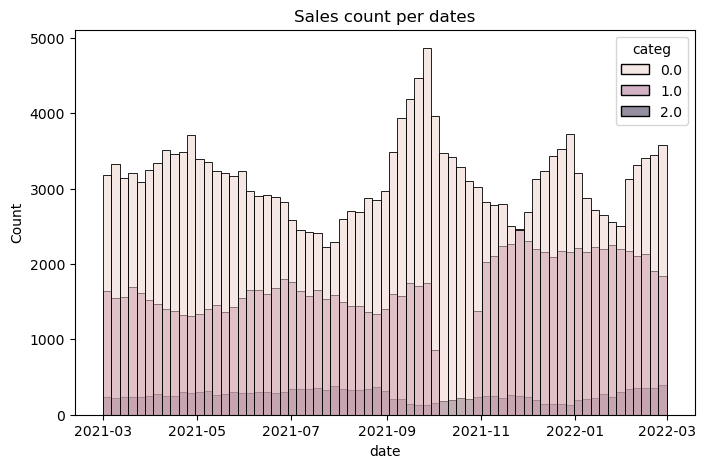

In [90]:
plt.figure(figsize=(8, 5))
sns.histplot(data=merged, x="date", hue="categ")
plt.title("Sales count per dates")
plt.show()

We can see that there are missing data between 2021-09 and 2021-11 for values in categ 1. Let's see it :

In [91]:
october_categ_1 = merged[((merged["date"] >= "2021-09") & (merged["date"] <= "2021-12")) & (merged["categ"] == 1)]
october_categ_1["date"].sort_values().dt.strftime("%Y-%m-%d").unique()

array(['2021-09-01', '2021-09-02', '2021-09-03', '2021-09-04',
       '2021-09-05', '2021-09-06', '2021-09-07', '2021-09-08',
       '2021-09-09', '2021-09-10', '2021-09-11', '2021-09-12',
       '2021-09-13', '2021-09-14', '2021-09-15', '2021-09-16',
       '2021-09-17', '2021-09-18', '2021-09-19', '2021-09-20',
       '2021-09-21', '2021-09-22', '2021-09-23', '2021-09-24',
       '2021-09-25', '2021-09-26', '2021-09-27', '2021-09-28',
       '2021-09-29', '2021-09-30', '2021-10-01', '2021-10-28',
       '2021-10-29', '2021-10-30', '2021-10-31', '2021-11-01',
       '2021-11-02', '2021-11-03', '2021-11-04', '2021-11-05',
       '2021-11-06', '2021-11-07', '2021-11-08', '2021-11-09',
       '2021-11-10', '2021-11-11', '2021-11-12', '2021-11-13',
       '2021-11-14', '2021-11-15', '2021-11-16', '2021-11-17',
       '2021-11-18', '2021-11-19', '2021-11-20', '2021-11-21',
       '2021-11-22', '2021-11-23', '2021-11-24', '2021-11-25',
       '2021-11-26', '2021-11-27', '2021-11-28', '2021-

We can see that it misses practically the whole october month. Instead add random values we decide to cut all datas in this period :

In [92]:
october_condition = ((merged["date"] >= "2021-10-01") & (merged["date"] <= "2021-10-31"))
len_before_deletion = len(merged)
merged.drop(merged[october_condition].index, inplace=True)
print(len_before_deletion - len(merged), "rows deleted")

20646 rows deleted


In [93]:
# We don't need this anymore
del october_categ_1
del october_condition
del len_before_deletion

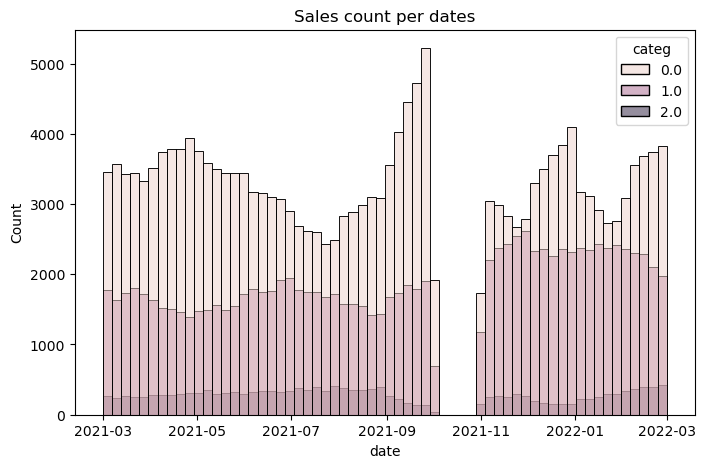

In [94]:
# Let's visualize our data now
plt.figure(figsize=(8, 5))
sns.histplot(data=merged, x="date", hue="categ")
plt.title("Sales count per dates")
plt.show()

We still have the problem of missing prices and categories :

In [95]:
merged.isnull().sum(), merged["price"].isnull().sum() / len(merged) * 100

(id_prod        0
 date           0
 session_id     0
 client_id      0
 sex            0
 birth          0
 price         96
 categ         96
 dtype: int64,
 0.03036341208843344)

Missing values represente 0.03 percent of our dataset. We can delete it :

In [96]:
merged.drop(merged[merged["price"].isnull()].index, inplace=True)
merged

,id_prod,date,session_id,client_id,sex,birth,price,categ
0,0_1483,2021-04-10 18:37:28.723910,s_18746,c_4450,f,1977-01-01,4.99,0.0
1,2_226,2022-02-03 01:55:53.276402,s_159142,c_277,f,2000-01-01,65.75,2.0
2,1_374,2021-09-23 15:13:46.938559,s_94290,c_4270,f,1979-01-01,10.71,1.0
4,0_1351,2021-07-17 20:34:25.800563,s_63642,c_1242,f,1980-01-01,8.99,0.0
5,0_1085,2021-09-15 05:47:48.215162,s_90139,c_2526,f,1982-01-01,3.99,0.0
...,...,...,...,...,...,...,...,...
336884,1_498,2022-02-03 01:39:15.793010,s_159138,c_1857,f,1990-01-01,23.37,1.0
336885,1_671,2021-05-28 12:35:46.214839,s_40720,c_3454,m,1969-01-01,31.99,1.0
336886,0_759,2021-06-19 00:19:23.917703,s_50568,c_6268,m,1991-01-01,22.99,0.0
336887,0_1256,2021-03-16 17:31:59.442007,s_7219,c_4137,f,1968-01-01,11.03,0.0


# Outliers detections

## Zscore

In [97]:
from scipy.stats import zscore
merged["zscore"] = merged["price"].pipe(zscore)
zscore_outliers = merged[merged["zscore"].abs() > 2]
zscore_outliers

,id_prod,date,session_id,client_id,sex,birth,price,categ,zscore
1,2_226,2022-02-03 01:55:53.276402,s_159142,c_277,f,2000-01-01,65.75,2.0,2.707802
27,2_135,2021-05-26 01:46:59.530702,s_39581,c_5192,m,1965-01-01,68.99,2.0,2.889186
73,2_208,2021-08-21 21:58:40.983725,s_78917,c_7881,m,1996-01-01,54.87,2.0,2.098710
111,2_139,2022-01-16 13:39:40.278930,s_150675,c_8517,f,2000-01-01,82.99,2.0,3.672944
132,2_62,2021-08-28 05:50:46.906391,s_81697,c_7806,f,1994-01-01,60.96,2.0,2.439645
...,...,...,...,...,...,...,...,...,...
336732,2_160,2021-04-03 20:56:24.950063,s_15576,c_7011,f,1996-01-01,62.83,2.0,2.544333
336750,2_208,2021-08-01 16:13:45.052960,s_70014,c_3158,f,1998-01-01,54.87,2.0,2.098710
336772,1_297,2022-01-29 00:51:38.850075,s_156672,c_592,f,1982-01-01,56.99,1.0,2.217394
336869,2_224,2021-06-18 10:49:10.960641,s_50302,c_4958,m,1999-01-01,87.40,2.0,3.919827


## Interquartile

In [98]:
q1, q3 = np.percentile(merged["price"], [25, 75])
iqr = q3 - q1

lower_range = q1 - (1.5 * iqr)
upper_range = q3 + (1.5 * iqr)

lower_range, upper_range

(-6.084999999999999, 34.114999999999995)

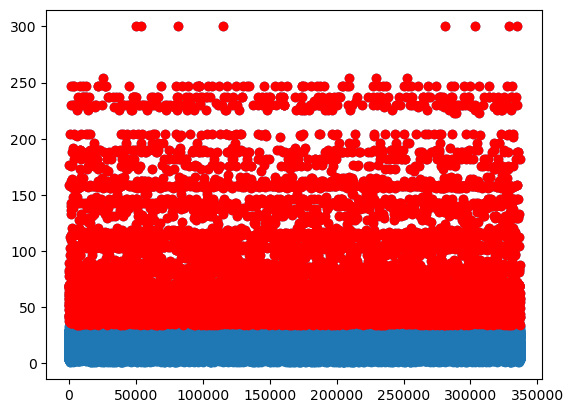

In [99]:
interquartile_outliers = merged[(merged["price"] < lower_range) | (merged["price"] > upper_range)]
scatter_with_outliers(
  x=merged.index,
  y=merged["price"],
  outliers_x=interquartile_outliers.index,
  outliers_y=interquartile_outliers["price"]
)

## Clustering

In [100]:
from sklearn.ensemble import IsolationForest
from sklearn.preprocessing import StandardScaler

In [101]:
scaler = StandardScaler()
scaled = scaler.fit_transform(merged[["price"]])
# train isolation forest
model =  IsolationForest(contamination=10e-4)
clustering_outliers = merged.iloc[np.where(model.fit_predict(scaled) == -1)]

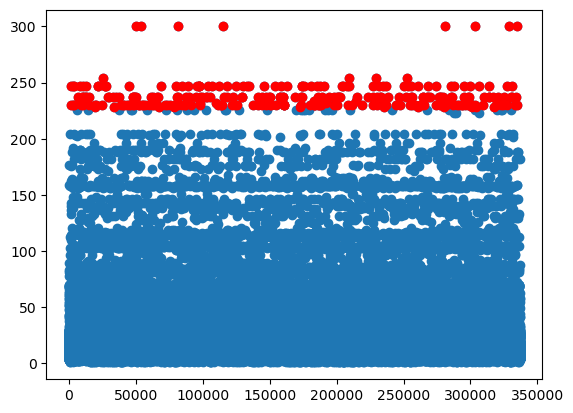

In [102]:
scatter_with_outliers(
  x=merged.index,
  y=merged["price"],
  outliers_x=clustering_outliers.index,
  outliers_y=clustering_outliers["price"]
)

# Scatter plot with the eye

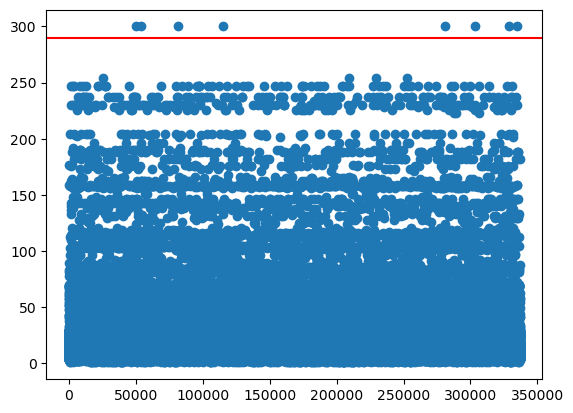

In [103]:
scatter_with_outliers(x=merged.index, y=merged["price"], outliers_y=290, type="htresh")

# Box plot

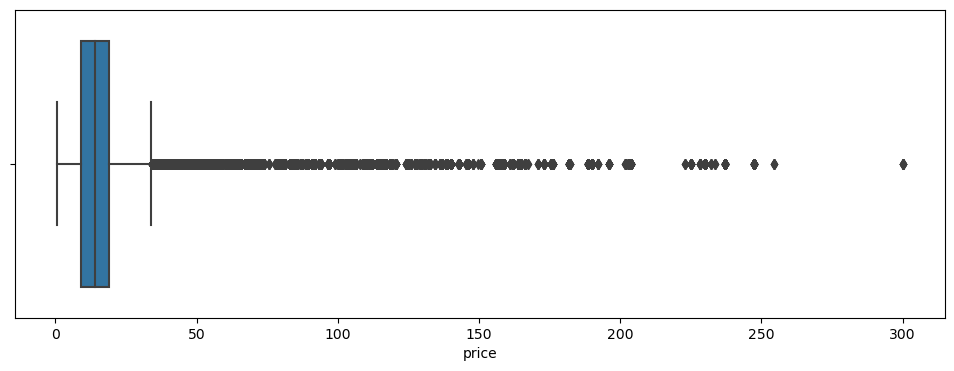

In [104]:
plt.figure(figsize=(12, 4))
sns.boxplot(x=merged["price"])
plt.show()

We decide to remove outliers from the clustering method

In [105]:
merged.drop(clustering_outliers.index, inplace=True)

# Data analysis

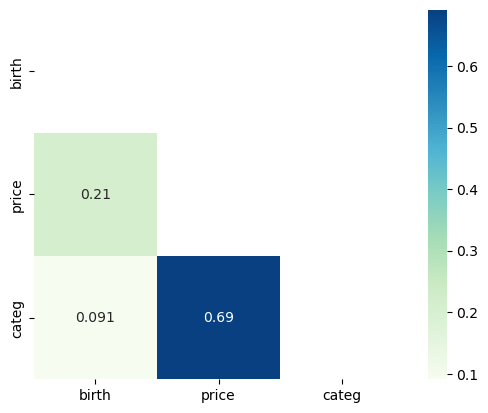

In [106]:
corr = merged[["birth", "price", "categ"]].corr(numeric_only=False)
sns.heatmap(corr, mask=corr_mask(corr.shape), annot=True, square=True, cmap="GnBu")
plt.show()

We can see that the variables "categ" and "price" are strongly correlated which means that the "categ" variable correspond to price ranges. Let's check :

In [107]:
# with mean compute
[
  f"Category {c} : {merged[merged['categ'] == c]['price'].mean()}"
  for c in merged["categ"].unique()
]

['Category 0.0 : 10.649107253046068',
 'Category 2.0 : 72.36952625712162',
 'Category 1.0 : 20.485778749388903']

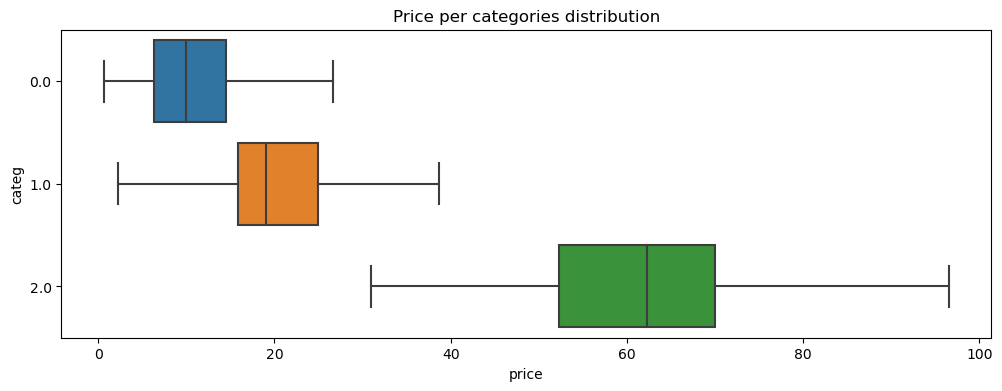

In [108]:
# with visualization
plt.figure(figsize=(12, 4))
sns.boxplot(data=merged, x="price", y="categ", orient="h", showfliers=False)
plt.title("Price per categories distribution")
plt.show()

## Create new variables from existing

In [109]:
merged["datetime"] = merged["date"]
merged["date"] = merged["datetime"].dt.date
merged["month"] = merged["datetime"]

In [110]:
merged

,id_prod,date,session_id,client_id,sex,birth,price,categ,zscore,datetime,month
0,0_1483,2021-04-10,s_18746,c_4450,f,1977-01-01,4.99,0.0,-0.693706,2021-04-10 18:37:28.723910,2021-04-10 18:37:28.723910
1,2_226,2022-02-03,s_159142,c_277,f,2000-01-01,65.75,2.0,2.707802,2022-02-03 01:55:53.276402,2022-02-03 01:55:53.276402
2,1_374,2021-09-23,s_94290,c_4270,f,1979-01-01,10.71,1.0,-0.373485,2021-09-23 15:13:46.938559,2021-09-23 15:13:46.938559
4,0_1351,2021-07-17,s_63642,c_1242,f,1980-01-01,8.99,0.0,-0.469776,2021-07-17 20:34:25.800563,2021-07-17 20:34:25.800563
5,0_1085,2021-09-15,s_90139,c_2526,f,1982-01-01,3.99,0.0,-0.749689,2021-09-15 05:47:48.215162,2021-09-15 05:47:48.215162
...,...,...,...,...,...,...,...,...,...,...,...
336884,1_498,2022-02-03,s_159138,c_1857,f,1990-01-01,23.37,1.0,0.335255,2022-02-03 01:39:15.793010,2022-02-03 01:39:15.793010
336885,1_671,2021-05-28,s_40720,c_3454,m,1969-01-01,31.99,1.0,0.817826,2021-05-28 12:35:46.214839,2021-05-28 12:35:46.214839
336886,0_759,2021-06-19,s_50568,c_6268,m,1991-01-01,22.99,0.0,0.313982,2021-06-19 00:19:23.917703,2021-06-19 00:19:23.917703
336887,0_1256,2021-03-16,s_7219,c_4137,f,1968-01-01,11.03,0.0,-0.355571,2021-03-16 17:31:59.442007,2021-03-16 17:31:59.442007


In [111]:
merged.pivot_table(index=["client_id", "date"]).reset_index().pivot_table(index="client_id").reset_index().rename(columns={"price": "panier_moyen"})

/var/folders/vj/r3vng6ks67sclkp5wn81gzt40000gn/T/ipykernel_77870/2950288198.py:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  merged.pivot_table(index=["client_id", "date"]).reset_index().pivot_table(index="client_id").reset_index().rename(columns={"price": "panier_moyen"})
/var/folders/vj/r3vng6ks67sclkp5wn81gzt40000gn/T/ipykernel_77870/2950288198.py:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  merged.pivot_table(index=["client_id", "date"]).reset_index().pivot_table(index="client_id").reset_index().rename(columns={"price": "panier_moyen"})


,client_id,categ,panier_moyen,zscore
0,c_1,0.242857,14.029929,-0.187627
1,c_10,0.693750,21.399156,0.224922
2,c_100,0.944444,36.678889,1.080323
3,c_1000,0.576577,17.024392,-0.019989
4,c_1001,0.295000,13.478358,-0.218505
...,...,...,...,...
8593,c_995,0.400000,15.906000,-0.082599
8594,c_996,0.607843,17.341814,-0.002219
8595,c_997,0.953704,28.485741,0.621648
8596,c_998,1.606838,67.085128,2.782546


In [112]:
# total sales
if not "total_sales" in merged.columns:
  merged = merged.merge(
    (merged[["client_id", "date"]]
      .groupby("client_id")
      .count()["date"]
      .reset_index()
      .rename({"date": "total_sales"}, axis=1)
    ),
    how="left",
    on="client_id"
  )

# average basket
if not "average_basket" in merged.columns:
  merged = merged.merge(
    merged.pivot_table(
      index=["client_id", "date"],
      values="price",
      aggfunc="mean"
    ).reset_index().pivot_table(
      index="client_id",
      aggfunc="mean"
    ).reset_index().rename(
      columns={"price": "average_basket"}
    ), 
    on="client_id",
    how="left"
  ).drop("date", axis=1)

if not "age" in merged.columns:
  from datetime import datetime
  year = datetime.now().year
  merged["age"] = year - merged["birth"].dt.year

if not "age_classe" in merged.columns:
  age_classe_mapper = {
    0: "18-30",
    1: "30-40",
    2: "40-50",
    3: "50-60",
    4: "60-70",
    5: "70-80",
    6: "80 et +"
  }
  merged["age_classe"] = 0
  merged["age_classe"].loc[merged[merged["age"]>=30].index] = 1
  merged["age_classe"].loc[merged[merged["age"]>=40].index] = 2
  merged["age_classe"].loc[merged[merged["age"]>=50].index] = 3
  merged["age_classe"].loc[merged[merged["age"]>=60].index] = 4
  merged["age_classe"].loc[merged[merged["age"]>=70].index] = 5
  merged["age_classe"].loc[merged[merged["age"]>=80].index] = 6

merged.sample(3)

/var/folders/vj/r3vng6ks67sclkp5wn81gzt40000gn/T/ipykernel_77870/2301902892.py:17: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  merged.pivot_table(
/var/folders/vj/r3vng6ks67sclkp5wn81gzt40000gn/T/ipykernel_77870/2301902892.py:47: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  merged["age_classe"].loc[merged[merged["age"]>=30].index] = 1
/var/folders/vj/r3vng6ks67sclkp5wn81gzt40000gn/T/ipykernel_77870/2301902892.py:48: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.ht

,id_prod,session_id,client_id,sex,birth,price,categ,zscore,datetime,month,total_sales,average_basket,age,age_classe
242686,0_1039,s_84399,c_4057,m,1981-01-01,11.99,0.0,-0.301828,2021-09-03 07:26:35.667497,2021-09-03 07:26:35.667497,104,12.820341,41,2
239432,0_881,s_18615,c_406,m,1972-01-01,18.99,0.0,0.090051,2021-04-10 11:52:59.568386,2021-04-10 11:52:59.568386,23,14.615704,50,3
192451,1_710,s_12409,c_3463,m,1995-01-01,27.94,1.0,0.591096,2021-03-28 00:43:28.803832,2021-03-28 00:43:28.803832,22,39.543958,27,0


## Lorenz & Gini curve

/var/folders/vj/r3vng6ks67sclkp5wn81gzt40000gn/T/ipykernel_77870/2164063527.py:2: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  _x = merged.pivot_table(index="client_id")["total_sales"]


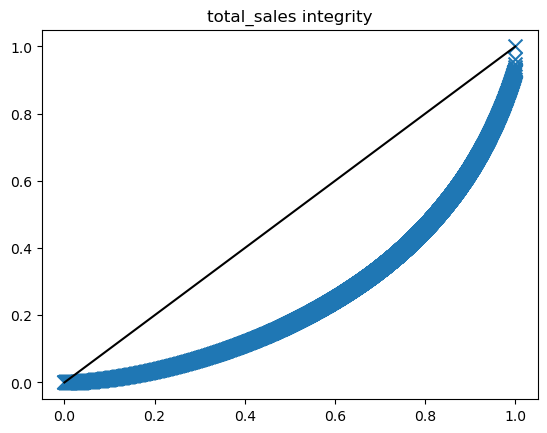

0.49479439879778564


In [113]:
fig, ax = plt.subplots()
_x = merged.pivot_table(index="client_id")["total_sales"]
lorenz_curve(X=_x, ax=ax)
plt.title("total_sales integrity")
plt.show()
print(gini(_x))

# Some plots

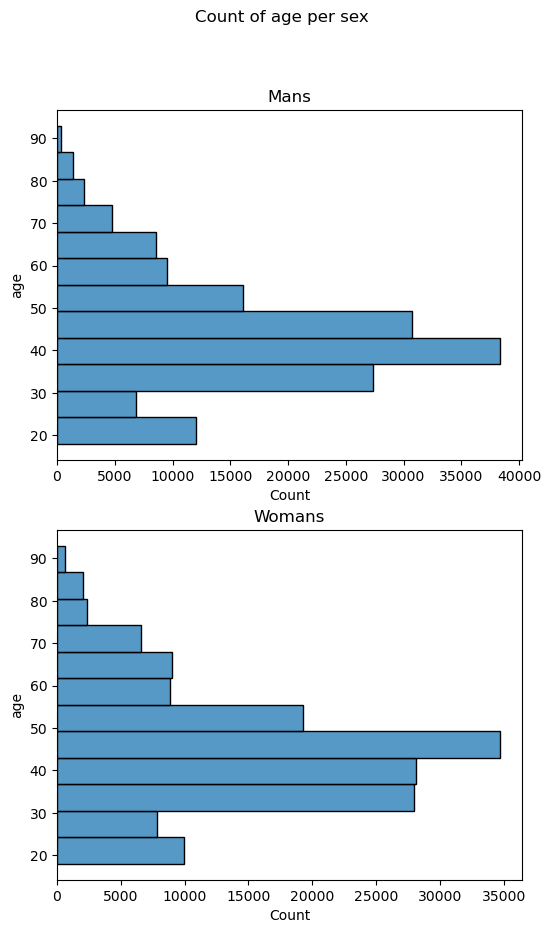

In [114]:
fig, axes = plt.subplots(2, figsize=(6, 10))
fig.suptitle("Count of age per sex")

sns.histplot(ax=axes[0], y=merged[merged["sex"]=="m"]["age"], bins=12)
axes[0].set_title("Mans")

sns.histplot(ax=axes[1], y=merged[merged["sex"]=="f"]["age"], bins=12)
axes[1].set_title("Womans")

plt.show()

We can see a small difference but the distribution looks same

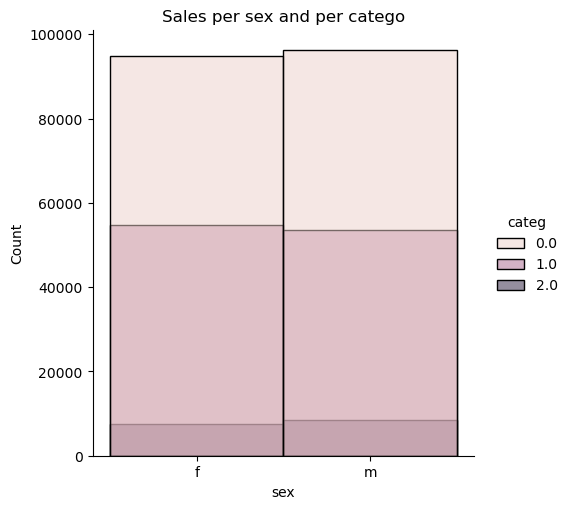

In [115]:
sns.displot(data=merged, x="sex", hue="categ")
plt.title("Sales per sex and per catego")
plt.show()

We see that the sales for each sex are balanced. The categories appear in the same proportions

<Figure size 800x500 with 0 Axes>

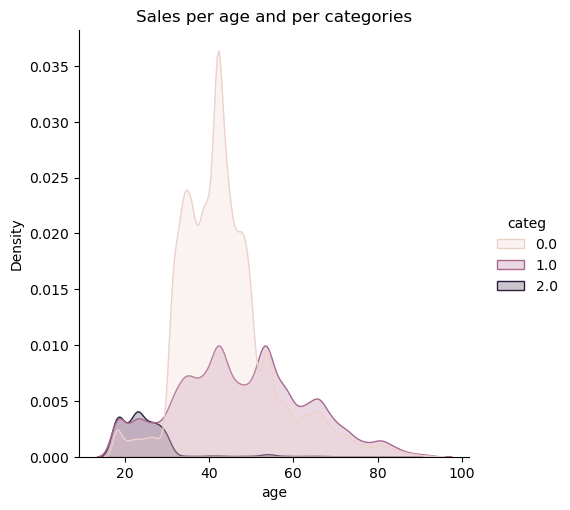

In [116]:
plt.figure(figsize=(8,5))
sns.displot(data=merged, x="age", hue="categ", kind="kde", fill=True)
plt.title("Sales per age and per categories")
plt.show()

The 2 categories are consumed by all age groups. But the buyers of category 0 are mainly those 30-50 years old, while category 2 is consumed almost exclusively by those under 30 years old

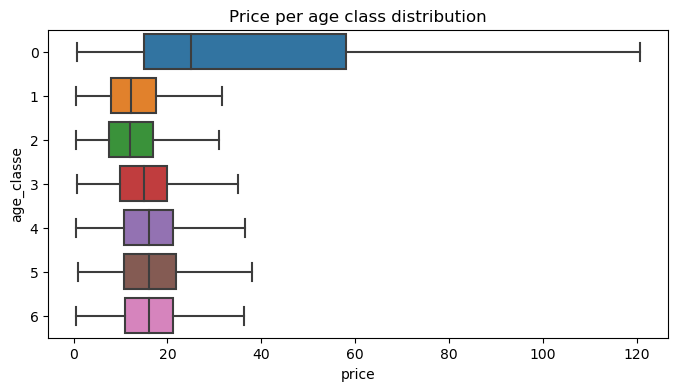

In [117]:
plt.figure(figsize=(8, 4))
sns.boxplot(data=merged.sort_values(by="age_classe"), y="age_classe", x="price", showfliers=False, orient="h")
plt.title("Price per age class distribution")
plt.show()

# Questions

Y a-t-il une corrélation entre le sexe des clients et les catégories de produits achetés ?

In [118]:
_df = merged.copy()
_df["sex"] = _df["sex"].map({
  "f": 0,
  "m": 1
})

<AxesSubplot: >

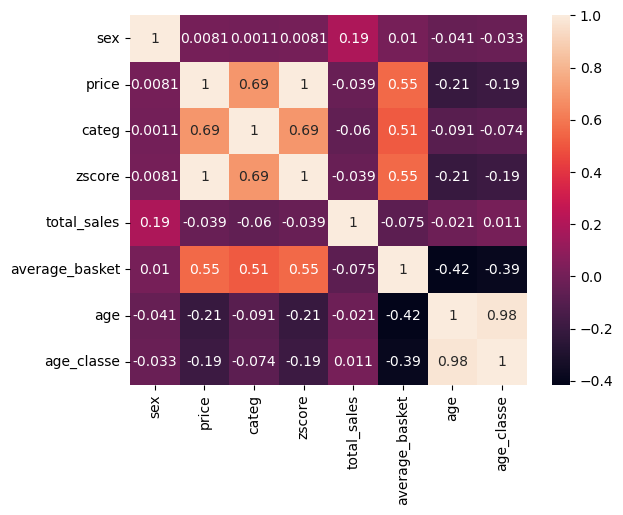

In [121]:
sns.heatmap(_df.corr(numeric_only=True), annot=True)

On peut voir qu'il n'y a pas de corrélation entre ces deux vairables

Y a-t-il une corrélation entre l'âge des clients et :

Il y a pas de corrélation entre c'est deux variable (-0.021)

La taille du panier moyen (en nombre d’articles):

On peut voir qu'il y a une corrélation entre ces deux variables mais elle n'est pas significative (-0.42)

Les catégories de produits achetés :

Comme ont peut le voir sur le graphique "Sales per age and per categories" il y a une forte coorélation entre ces deux variables